# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import LSTMAE, FCAE, train_autoencoder

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False
TEST_EXISTING_MODEL = False

In [4]:
model_name = "LSTM_AE"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0002,
    "batch_size": 32,
    "num_epochs": 2000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [5]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_1y.csv")
traffic_df.shape

(8759, 5)

In [6]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(8759, 5)

### Preprocessing

In [7]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [8]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [9]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)


In [10]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [11]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [12]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [13]:
if model_name == "LSTM_AE":
    model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    model = FCAE(verbose=False).to(hyperparameters['device'])

In [14]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

  0%|          | 1/2000 [00:00<14:39,  2.27it/s]

Epoch: 0 
 Train Loss: 0.27198295996069366 
 Val Loss: 0.22643136978149414
**************************************************


  1%|          | 18/2000 [00:07<13:24,  2.47it/s]

INFO: Validation loss did not improve in epoch 18


  1%|▏         | 26/2000 [00:10<13:11,  2.50it/s]

Epoch: 25 
 Train Loss: 0.16827853486690347 
 Val Loss: 0.1612011675855943
**************************************************


  3%|▎         | 51/2000 [00:23<15:42,  2.07it/s]

Epoch: 50 
 Train Loss: 0.13256924987247545 
 Val Loss: 0.13567037933639117
**************************************************


  4%|▍         | 76/2000 [00:35<13:09,  2.44it/s]

Epoch: 75 
 Train Loss: 0.10778405173728454 
 Val Loss: 0.09541595966688224
**************************************************


  5%|▌         | 101/2000 [00:45<13:01,  2.43it/s]

Epoch: 100 
 Train Loss: 0.08847567660215239 
 Val Loss: 0.07601852954498359
**************************************************


  6%|▋         | 126/2000 [00:56<12:58,  2.41it/s]

Epoch: 125 
 Train Loss: 0.08186962433397497 
 Val Loss: 0.0659410831119333
**************************************************


  7%|▋         | 134/2000 [01:00<13:43,  2.26it/s]

INFO: Validation loss did not improve in epoch 134


  7%|▋         | 137/2000 [01:01<12:53,  2.41it/s]

INFO: Validation loss did not improve in epoch 137


  7%|▋         | 143/2000 [01:03<12:24,  2.50it/s]

INFO: Validation loss did not improve in epoch 143


  8%|▊         | 151/2000 [01:07<15:45,  1.96it/s]

INFO: Validation loss did not improve in epoch 151
Epoch: 150 
 Train Loss: 0.08084695847475365 
 Val Loss: 0.06519938632845879
**************************************************


  8%|▊         | 152/2000 [01:08<18:16,  1.69it/s]

INFO: Validation loss did not improve in epoch 152


  9%|▊         | 172/2000 [01:17<15:34,  1.96it/s]

INFO: Validation loss did not improve in epoch 172


  9%|▉         | 176/2000 [01:20<16:59,  1.79it/s]

Epoch: 175 
 Train Loss: 0.07989097927531151 
 Val Loss: 0.06439301504620484
**************************************************


  9%|▉         | 180/2000 [01:22<17:14,  1.76it/s]

INFO: Validation loss did not improve in epoch 180


  9%|▉         | 182/2000 [01:23<15:59,  1.89it/s]

INFO: Validation loss did not improve in epoch 182


  9%|▉         | 184/2000 [01:24<17:26,  1.74it/s]

INFO: Validation loss did not improve in epoch 184


 10%|█         | 201/2000 [01:32<13:44,  2.18it/s]

Epoch: 200 
 Train Loss: 0.07914405521940968 
 Val Loss: 0.0635421144376908
**************************************************


 10%|█         | 204/2000 [01:34<13:26,  2.23it/s]

INFO: Validation loss did not improve in epoch 204


 10%|█         | 208/2000 [01:36<13:34,  2.20it/s]

INFO: Validation loss did not improve in epoch 208


 11%|█         | 211/2000 [01:37<13:38,  2.18it/s]

INFO: Validation loss did not improve in epoch 211


 11%|█▏        | 226/2000 [01:44<13:05,  2.26it/s]

Epoch: 225 
 Train Loss: 0.06878170891575618 
 Val Loss: 0.05743171860064779
**************************************************


 12%|█▏        | 232/2000 [01:47<13:05,  2.25it/s]

INFO: Validation loss did not improve in epoch 232


 12%|█▏        | 233/2000 [01:47<13:24,  2.20it/s]

INFO: Validation loss did not improve in epoch 233


 12%|█▏        | 237/2000 [01:49<14:34,  2.02it/s]

INFO: Validation loss did not improve in epoch 237


 12%|█▏        | 248/2000 [01:55<15:03,  1.94it/s]

INFO: Validation loss did not improve in epoch 248


 12%|█▏        | 249/2000 [01:55<14:34,  2.00it/s]

INFO: Validation loss did not improve in epoch 249


 13%|█▎        | 251/2000 [01:56<14:29,  2.01it/s]

INFO: Validation loss did not improve in epoch 251
Epoch: 250 
 Train Loss: 0.06831921094424648 
 Val Loss: 0.056831950188747475
**************************************************


 13%|█▎        | 254/2000 [01:58<13:11,  2.21it/s]

INFO: Validation loss did not improve in epoch 254


 13%|█▎        | 256/2000 [01:58<13:04,  2.22it/s]

INFO: Validation loss did not improve in epoch 256


 13%|█▎        | 258/2000 [01:59<13:07,  2.21it/s]

INFO: Validation loss did not improve in epoch 258


 13%|█▎        | 259/2000 [02:00<12:52,  2.25it/s]

INFO: Validation loss did not improve in epoch 259


 13%|█▎        | 260/2000 [02:00<14:01,  2.07it/s]

INFO: Validation loss did not improve in epoch 260


 13%|█▎        | 262/2000 [02:01<13:36,  2.13it/s]

INFO: Validation loss did not improve in epoch 262


 13%|█▎        | 265/2000 [02:03<14:00,  2.07it/s]

INFO: Validation loss did not improve in epoch 265


 13%|█▎        | 266/2000 [02:03<13:47,  2.09it/s]

INFO: Validation loss did not improve in epoch 266


 14%|█▎        | 270/2000 [02:05<14:41,  1.96it/s]

INFO: Validation loss did not improve in epoch 270


 14%|█▎        | 271/2000 [02:06<14:30,  1.99it/s]

INFO: Validation loss did not improve in epoch 271


 14%|█▎        | 272/2000 [02:06<14:13,  2.03it/s]

INFO: Validation loss did not improve in epoch 272


 14%|█▎        | 273/2000 [02:07<15:07,  1.90it/s]

INFO: Validation loss did not improve in epoch 273


 14%|█▍        | 276/2000 [02:08<13:47,  2.08it/s]

Epoch: 275 
 Train Loss: 0.0680466846618206 
 Val Loss: 0.05646133555897644
**************************************************


 14%|█▍        | 279/2000 [02:10<13:38,  2.10it/s]

INFO: Validation loss did not improve in epoch 279


 14%|█▍        | 287/2000 [02:14<13:50,  2.06it/s]

INFO: Validation loss did not improve in epoch 287


 15%|█▍        | 292/2000 [02:16<14:04,  2.02it/s]

INFO: Validation loss did not improve in epoch 292


 15%|█▍        | 295/2000 [02:18<14:10,  2.00it/s]

INFO: Validation loss did not improve in epoch 295


 15%|█▍        | 298/2000 [02:19<12:55,  2.20it/s]

INFO: Validation loss did not improve in epoch 298


 15%|█▌        | 300/2000 [02:20<12:33,  2.26it/s]

INFO: Validation loss did not improve in epoch 300


 15%|█▌        | 301/2000 [02:21<12:26,  2.28it/s]

INFO: Validation loss did not improve in epoch 301
Epoch: 300 
 Train Loss: 0.06777144017625072 
 Val Loss: 0.05606682811464582
**************************************************


 15%|█▌        | 306/2000 [02:23<13:49,  2.04it/s]

INFO: Validation loss did not improve in epoch 306


 15%|█▌        | 307/2000 [02:24<14:13,  1.98it/s]

INFO: Validation loss did not improve in epoch 307


 15%|█▌        | 308/2000 [02:24<14:38,  1.93it/s]

INFO: Validation loss did not improve in epoch 308


 16%|█▌        | 311/2000 [02:26<14:58,  1.88it/s]

INFO: Validation loss did not improve in epoch 311


 16%|█▌        | 312/2000 [02:26<15:30,  1.82it/s]

INFO: Validation loss did not improve in epoch 312


 16%|█▌        | 313/2000 [02:27<15:22,  1.83it/s]

INFO: Validation loss did not improve in epoch 313


 16%|█▌        | 314/2000 [02:28<15:57,  1.76it/s]

INFO: Validation loss did not improve in epoch 314


 16%|█▌        | 315/2000 [02:28<15:53,  1.77it/s]

INFO: Validation loss did not improve in epoch 315


 16%|█▌        | 316/2000 [02:29<16:44,  1.68it/s]

INFO: Validation loss did not improve in epoch 316


 16%|█▌        | 317/2000 [02:29<16:09,  1.74it/s]

INFO: Validation loss did not improve in epoch 317


 16%|█▌        | 318/2000 [02:30<16:11,  1.73it/s]

INFO: Validation loss did not improve in epoch 318


 16%|█▌        | 324/2000 [02:33<13:34,  2.06it/s]

INFO: Validation loss did not improve in epoch 324


 16%|█▋        | 325/2000 [02:34<15:19,  1.82it/s]

INFO: Validation loss did not improve in epoch 325


 16%|█▋        | 326/2000 [02:34<16:13,  1.72it/s]

Epoch: 325 
 Train Loss: 0.06753093359745256 
 Val Loss: 0.05580470458205257
**************************************************


 16%|█▋        | 327/2000 [02:35<15:07,  1.84it/s]

INFO: Validation loss did not improve in epoch 327


 16%|█▋        | 328/2000 [02:35<14:56,  1.86it/s]

INFO: Validation loss did not improve in epoch 328


 17%|█▋        | 331/2000 [02:37<14:19,  1.94it/s]

INFO: Validation loss did not improve in epoch 331


 17%|█▋        | 333/2000 [02:38<14:54,  1.86it/s]

INFO: Validation loss did not improve in epoch 333


 17%|█▋        | 335/2000 [02:39<14:14,  1.95it/s]

INFO: Validation loss did not improve in epoch 335


 17%|█▋        | 336/2000 [02:39<13:41,  2.02it/s]

INFO: Validation loss did not improve in epoch 336


 17%|█▋        | 337/2000 [02:40<13:18,  2.08it/s]

INFO: Validation loss did not improve in epoch 337


 17%|█▋        | 339/2000 [02:41<12:59,  2.13it/s]

INFO: Validation loss did not improve in epoch 339


 17%|█▋        | 341/2000 [02:42<13:02,  2.12it/s]

INFO: Validation loss did not improve in epoch 341


 17%|█▋        | 343/2000 [02:43<13:47,  2.00it/s]

INFO: Validation loss did not improve in epoch 343


 17%|█▋        | 344/2000 [02:43<14:08,  1.95it/s]

INFO: Validation loss did not improve in epoch 344


 17%|█▋        | 345/2000 [02:44<15:17,  1.80it/s]

INFO: Validation loss did not improve in epoch 345


 17%|█▋        | 346/2000 [02:44<14:50,  1.86it/s]

INFO: Validation loss did not improve in epoch 346


 17%|█▋        | 347/2000 [02:45<14:40,  1.88it/s]

INFO: Validation loss did not improve in epoch 347


 18%|█▊        | 350/2000 [02:46<14:05,  1.95it/s]

INFO: Validation loss did not improve in epoch 350


 18%|█▊        | 351/2000 [02:47<14:01,  1.96it/s]

Epoch: 350 
 Train Loss: 0.06730675864029148 
 Val Loss: 0.05558605771511793
**************************************************


 18%|█▊        | 352/2000 [02:47<14:17,  1.92it/s]

INFO: Validation loss did not improve in epoch 352


 18%|█▊        | 353/2000 [02:48<15:52,  1.73it/s]

INFO: Validation loss did not improve in epoch 353


 18%|█▊        | 357/2000 [02:50<14:44,  1.86it/s]

INFO: Validation loss did not improve in epoch 357


 18%|█▊        | 358/2000 [02:51<15:05,  1.81it/s]

INFO: Validation loss did not improve in epoch 358


 18%|█▊        | 360/2000 [02:52<16:30,  1.66it/s]

INFO: Validation loss did not improve in epoch 360


 18%|█▊        | 361/2000 [02:53<16:23,  1.67it/s]

INFO: Validation loss did not improve in epoch 361


 18%|█▊        | 362/2000 [02:53<16:02,  1.70it/s]

INFO: Validation loss did not improve in epoch 362


 18%|█▊        | 363/2000 [02:54<15:51,  1.72it/s]

INFO: Validation loss did not improve in epoch 363


 18%|█▊        | 365/2000 [02:55<15:40,  1.74it/s]

INFO: Validation loss did not improve in epoch 365


 18%|█▊        | 366/2000 [02:56<15:40,  1.74it/s]

INFO: Validation loss did not improve in epoch 366


 18%|█▊        | 367/2000 [02:56<15:18,  1.78it/s]

INFO: Validation loss did not improve in epoch 367


 18%|█▊        | 369/2000 [02:57<15:19,  1.77it/s]

INFO: Validation loss did not improve in epoch 369


 19%|█▊        | 371/2000 [02:58<14:40,  1.85it/s]

INFO: Validation loss did not improve in epoch 371


 19%|█▊        | 373/2000 [03:00<15:43,  1.72it/s]

INFO: Validation loss did not improve in epoch 373


 19%|█▊        | 374/2000 [03:00<17:43,  1.53it/s]

INFO: Validation loss did not improve in epoch 374


 19%|█▉        | 375/2000 [03:01<18:21,  1.48it/s]

INFO: Validation loss did not improve in epoch 375


 19%|█▉        | 376/2000 [03:02<17:15,  1.57it/s]

INFO: Validation loss did not improve in epoch 376
Epoch: 375 
 Train Loss: 0.06709316013100212 
 Val Loss: 0.055476034193166664
**************************************************


 19%|█▉        | 377/2000 [03:02<16:44,  1.62it/s]

INFO: Validation loss did not improve in epoch 377


 19%|█▉        | 378/2000 [03:03<15:46,  1.71it/s]

INFO: Validation loss did not improve in epoch 378


 19%|█▉        | 380/2000 [03:04<14:35,  1.85it/s]

INFO: Validation loss did not improve in epoch 380


 19%|█▉        | 382/2000 [03:05<13:58,  1.93it/s]

INFO: Validation loss did not improve in epoch 382


 19%|█▉        | 383/2000 [03:05<13:49,  1.95it/s]

INFO: Validation loss did not improve in epoch 383


 19%|█▉        | 384/2000 [03:06<13:41,  1.97it/s]

INFO: Validation loss did not improve in epoch 384


 19%|█▉        | 385/2000 [03:06<14:56,  1.80it/s]

INFO: Validation loss did not improve in epoch 385


 19%|█▉        | 387/2000 [03:08<15:31,  1.73it/s]

INFO: Validation loss did not improve in epoch 387


 20%|█▉        | 390/2000 [03:10<17:16,  1.55it/s]

INFO: Validation loss did not improve in epoch 390


 20%|█▉        | 391/2000 [03:10<16:23,  1.64it/s]

INFO: Validation loss did not improve in epoch 391


 20%|█▉        | 392/2000 [03:11<15:48,  1.70it/s]

INFO: Validation loss did not improve in epoch 392


 20%|█▉        | 393/2000 [03:11<15:05,  1.77it/s]

INFO: Validation loss did not improve in epoch 393


 20%|█▉        | 394/2000 [03:12<14:46,  1.81it/s]

INFO: Validation loss did not improve in epoch 394


 20%|█▉        | 395/2000 [03:12<15:14,  1.76it/s]

INFO: Validation loss did not improve in epoch 395


 20%|█▉        | 396/2000 [03:13<14:43,  1.82it/s]

INFO: Validation loss did not improve in epoch 396


 20%|█▉        | 397/2000 [03:13<14:10,  1.88it/s]

INFO: Validation loss did not improve in epoch 397


 20%|█▉        | 398/2000 [03:14<13:39,  1.95it/s]

INFO: Validation loss did not improve in epoch 398


 20%|██        | 400/2000 [03:15<13:37,  1.96it/s]

INFO: Validation loss did not improve in epoch 400


 20%|██        | 401/2000 [03:15<13:13,  2.02it/s]

Epoch: 400 
 Train Loss: 0.06684486851198217 
 Val Loss: 0.05539109770740781
**************************************************


 20%|██        | 402/2000 [03:16<13:15,  2.01it/s]

INFO: Validation loss did not improve in epoch 402


 20%|██        | 404/2000 [03:17<13:36,  1.95it/s]

INFO: Validation loss did not improve in epoch 404


 20%|██        | 405/2000 [03:17<13:53,  1.91it/s]

INFO: Validation loss did not improve in epoch 405


 20%|██        | 406/2000 [03:18<13:34,  1.96it/s]

INFO: Validation loss did not improve in epoch 406


 20%|██        | 407/2000 [03:18<13:57,  1.90it/s]

INFO: Validation loss did not improve in epoch 407


 20%|██        | 408/2000 [03:19<13:42,  1.94it/s]

INFO: Validation loss did not improve in epoch 408


 20%|██        | 409/2000 [03:19<13:58,  1.90it/s]

INFO: Validation loss did not improve in epoch 409


 20%|██        | 410/2000 [03:20<14:34,  1.82it/s]

INFO: Validation loss did not improve in epoch 410


 21%|██        | 414/2000 [03:22<14:09,  1.87it/s]

INFO: Validation loss did not improve in epoch 414


 21%|██        | 417/2000 [03:24<13:49,  1.91it/s]

INFO: Validation loss did not improve in epoch 417


 21%|██        | 419/2000 [03:25<15:07,  1.74it/s]

INFO: Validation loss did not improve in epoch 419


 21%|██▏       | 426/2000 [03:29<14:22,  1.82it/s]

Epoch: 425 
 Train Loss: 0.06644276300759892 
 Val Loss: 0.05508578249386379
**************************************************


 21%|██▏       | 428/2000 [03:30<15:58,  1.64it/s]

INFO: Validation loss did not improve in epoch 428


 22%|██▏       | 430/2000 [03:31<16:04,  1.63it/s]

INFO: Validation loss did not improve in epoch 430


 22%|██▏       | 437/2000 [03:35<12:44,  2.04it/s]

INFO: Validation loss did not improve in epoch 437


 23%|██▎       | 451/2000 [03:41<12:48,  2.02it/s]

Epoch: 450 
 Train Loss: 0.05585029819920727 
 Val Loss: 0.04962359501847199
**************************************************


 23%|██▎       | 462/2000 [03:47<13:49,  1.85it/s]

INFO: Validation loss did not improve in epoch 462


 24%|██▎       | 470/2000 [03:52<13:39,  1.87it/s]

INFO: Validation loss did not improve in epoch 470


 24%|██▎       | 472/2000 [03:53<13:03,  1.95it/s]

INFO: Validation loss did not improve in epoch 472


 24%|██▎       | 474/2000 [03:54<13:03,  1.95it/s]

INFO: Validation loss did not improve in epoch 474


 24%|██▍       | 475/2000 [03:55<13:16,  1.91it/s]

INFO: Validation loss did not improve in epoch 475


 24%|██▍       | 476/2000 [03:55<15:28,  1.64it/s]

INFO: Validation loss did not improve in epoch 476
Epoch: 475 
 Train Loss: 0.053240163872639336 
 Val Loss: 0.04829955593283687
**************************************************


 24%|██▍       | 485/2000 [04:00<15:26,  1.64it/s]

INFO: Validation loss did not improve in epoch 485


 24%|██▍       | 488/2000 [04:02<14:56,  1.69it/s]

INFO: Validation loss did not improve in epoch 488


 24%|██▍       | 489/2000 [04:03<14:47,  1.70it/s]

INFO: Validation loss did not improve in epoch 489


 25%|██▍       | 494/2000 [04:06<15:53,  1.58it/s]

INFO: Validation loss did not improve in epoch 494


 25%|██▍       | 495/2000 [04:06<15:18,  1.64it/s]

INFO: Validation loss did not improve in epoch 495


 25%|██▌       | 500/2000 [04:09<15:20,  1.63it/s]/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_generation/AE/AE.py:172: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
 25%|██▌       | 501/2000 [04:10<14:36,  1.71it/s]

Epoch: 500 
 Train Loss: 0.05236551620610501 
 Val Loss: 0.04743078231279339
**************************************************


 25%|██▌       | 502/2000 [04:11<15:12,  1.64it/s]

INFO: Validation loss did not improve in epoch 502


 25%|██▌       | 505/2000 [04:12<14:25,  1.73it/s]

INFO: Validation loss did not improve in epoch 505


 25%|██▌       | 506/2000 [04:13<14:26,  1.72it/s]

INFO: Validation loss did not improve in epoch 506


 26%|██▌       | 512/2000 [04:16<13:21,  1.86it/s]

INFO: Validation loss did not improve in epoch 512


 26%|██▌       | 514/2000 [04:17<12:38,  1.96it/s]

INFO: Validation loss did not improve in epoch 514


 26%|██▌       | 516/2000 [04:18<12:06,  2.04it/s]

INFO: Validation loss did not improve in epoch 516


 26%|██▌       | 521/2000 [04:20<11:25,  2.16it/s]

INFO: Validation loss did not improve in epoch 521


 26%|██▌       | 524/2000 [04:22<11:22,  2.16it/s]

INFO: Validation loss did not improve in epoch 524


 26%|██▋       | 525/2000 [04:22<11:53,  2.07it/s]

INFO: Validation loss did not improve in epoch 525


 26%|██▋       | 526/2000 [04:23<13:24,  1.83it/s]

INFO: Validation loss did not improve in epoch 526
Epoch: 525 
 Train Loss: 0.05187994693342137 
 Val Loss: 0.04701577605945723
**************************************************


 26%|██▋       | 527/2000 [04:24<13:45,  1.78it/s]

INFO: Validation loss did not improve in epoch 527


 26%|██▋       | 528/2000 [04:24<13:40,  1.79it/s]

INFO: Validation loss did not improve in epoch 528


 26%|██▋       | 530/2000 [04:25<14:08,  1.73it/s]

INFO: Validation loss did not improve in epoch 530


 27%|██▋       | 533/2000 [04:27<15:47,  1.55it/s]

INFO: Validation loss did not improve in epoch 533


 27%|██▋       | 534/2000 [04:28<14:43,  1.66it/s]

INFO: Validation loss did not improve in epoch 534


 27%|██▋       | 538/2000 [04:30<12:46,  1.91it/s]

INFO: Validation loss did not improve in epoch 538


 27%|██▋       | 546/2000 [04:34<11:23,  2.13it/s]

INFO: Validation loss did not improve in epoch 546


 27%|██▋       | 549/2000 [04:35<13:41,  1.77it/s]

INFO: Validation loss did not improve in epoch 549


 28%|██▊       | 551/2000 [04:37<14:59,  1.61it/s]

Epoch: 550 
 Train Loss: 0.051453313182137875 
 Val Loss: 0.046470176694648604
**************************************************


 28%|██▊       | 553/2000 [04:38<17:02,  1.41it/s]

INFO: Validation loss did not improve in epoch 553


 28%|██▊       | 555/2000 [04:40<15:04,  1.60it/s]

INFO: Validation loss did not improve in epoch 555


 28%|██▊       | 556/2000 [04:40<14:12,  1.69it/s]

INFO: Validation loss did not improve in epoch 556


 28%|██▊       | 567/2000 [04:46<11:06,  2.15it/s]

INFO: Validation loss did not improve in epoch 567


 29%|██▊       | 571/2000 [04:47<10:51,  2.19it/s]

INFO: Validation loss did not improve in epoch 571


 29%|██▊       | 572/2000 [04:48<10:49,  2.20it/s]

INFO: Validation loss did not improve in epoch 572


 29%|██▊       | 573/2000 [04:48<11:12,  2.12it/s]

INFO: Validation loss did not improve in epoch 573


 29%|██▉       | 575/2000 [04:49<11:00,  2.16it/s]

INFO: Validation loss did not improve in epoch 575


 29%|██▉       | 576/2000 [04:50<11:19,  2.10it/s]

Epoch: 575 
 Train Loss: 0.051105696597395965 
 Val Loss: 0.04604340231578265
**************************************************


 29%|██▉       | 578/2000 [04:51<11:52,  2.00it/s]

INFO: Validation loss did not improve in epoch 578


 29%|██▉       | 581/2000 [04:52<11:30,  2.06it/s]

INFO: Validation loss did not improve in epoch 581


 29%|██▉       | 582/2000 [04:53<11:24,  2.07it/s]

INFO: Validation loss did not improve in epoch 582


 30%|██▉       | 593/2000 [04:58<10:42,  2.19it/s]

INFO: Validation loss did not improve in epoch 593


 30%|██▉       | 594/2000 [04:58<10:40,  2.19it/s]

INFO: Validation loss did not improve in epoch 594


 30%|██▉       | 595/2000 [04:59<10:46,  2.17it/s]

INFO: Validation loss did not improve in epoch 595


 30%|██▉       | 596/2000 [04:59<10:47,  2.17it/s]

INFO: Validation loss did not improve in epoch 596


 30%|██▉       | 598/2000 [05:00<10:51,  2.15it/s]

INFO: Validation loss did not improve in epoch 598


 30%|██▉       | 599/2000 [05:01<10:47,  2.17it/s]

INFO: Validation loss did not improve in epoch 599


 30%|███       | 601/2000 [05:02<10:48,  2.16it/s]

Epoch: 600 
 Train Loss: 0.05081268747817708 
 Val Loss: 0.0456539563435529
**************************************************


 30%|███       | 604/2000 [05:03<12:14,  1.90it/s]

INFO: Validation loss did not improve in epoch 604


 30%|███       | 605/2000 [05:04<11:56,  1.95it/s]

INFO: Validation loss did not improve in epoch 605


 30%|███       | 607/2000 [05:05<11:15,  2.06it/s]

INFO: Validation loss did not improve in epoch 607


 30%|███       | 610/2000 [05:06<10:50,  2.14it/s]

INFO: Validation loss did not improve in epoch 610


 31%|███       | 614/2000 [05:08<10:53,  2.12it/s]

INFO: Validation loss did not improve in epoch 614


 31%|███       | 615/2000 [05:08<10:43,  2.15it/s]

INFO: Validation loss did not improve in epoch 615


 31%|███       | 616/2000 [05:09<10:40,  2.16it/s]

INFO: Validation loss did not improve in epoch 616


 31%|███       | 617/2000 [05:09<10:40,  2.16it/s]

INFO: Validation loss did not improve in epoch 617


 31%|███       | 621/2000 [05:11<10:26,  2.20it/s]

INFO: Validation loss did not improve in epoch 621


 31%|███       | 622/2000 [05:11<10:23,  2.21it/s]

INFO: Validation loss did not improve in epoch 622


 31%|███       | 623/2000 [05:12<10:23,  2.21it/s]

INFO: Validation loss did not improve in epoch 623


 31%|███▏      | 625/2000 [05:13<10:39,  2.15it/s]

INFO: Validation loss did not improve in epoch 625


 31%|███▏      | 626/2000 [05:13<10:34,  2.17it/s]

INFO: Validation loss did not improve in epoch 626
Epoch: 625 
 Train Loss: 0.05055295272845112 
 Val Loss: 0.04542438619370971
**************************************************


 31%|███▏      | 628/2000 [05:14<10:28,  2.18it/s]

INFO: Validation loss did not improve in epoch 628


 32%|███▏      | 630/2000 [05:15<10:23,  2.20it/s]

INFO: Validation loss did not improve in epoch 630


 32%|███▏      | 631/2000 [05:16<10:19,  2.21it/s]

INFO: Validation loss did not improve in epoch 631


 32%|███▏      | 632/2000 [05:16<10:18,  2.21it/s]

INFO: Validation loss did not improve in epoch 632


 32%|███▏      | 633/2000 [05:17<10:22,  2.20it/s]

INFO: Validation loss did not improve in epoch 633


 32%|███▏      | 634/2000 [05:17<10:21,  2.20it/s]

INFO: Validation loss did not improve in epoch 634


 32%|███▏      | 635/2000 [05:17<10:20,  2.20it/s]

INFO: Validation loss did not improve in epoch 635


 32%|███▏      | 637/2000 [05:18<10:31,  2.16it/s]

INFO: Validation loss did not improve in epoch 637


 32%|███▏      | 638/2000 [05:19<11:06,  2.04it/s]

INFO: Validation loss did not improve in epoch 638


 32%|███▏      | 639/2000 [05:19<10:58,  2.07it/s]

INFO: Validation loss did not improve in epoch 639


 32%|███▏      | 641/2000 [05:20<11:25,  1.98it/s]

INFO: Validation loss did not improve in epoch 641


 32%|███▏      | 642/2000 [05:21<11:01,  2.05it/s]

INFO: Validation loss did not improve in epoch 642


 32%|███▏      | 645/2000 [05:22<10:21,  2.18it/s]

INFO: Validation loss did not improve in epoch 645


 32%|███▏      | 646/2000 [05:23<10:14,  2.20it/s]

INFO: Validation loss did not improve in epoch 646


 32%|███▏      | 649/2000 [05:24<10:04,  2.23it/s]

INFO: Validation loss did not improve in epoch 649


 32%|███▎      | 650/2000 [05:24<10:03,  2.24it/s]

INFO: Validation loss did not improve in epoch 650


 33%|███▎      | 651/2000 [05:25<10:05,  2.23it/s]

Epoch: 650 
 Train Loss: 0.05032161604528013 
 Val Loss: 0.04522911711995091
**************************************************


 33%|███▎      | 652/2000 [05:25<10:04,  2.23it/s]

INFO: Validation loss did not improve in epoch 652


 33%|███▎      | 655/2000 [05:27<10:05,  2.22it/s]

INFO: Validation loss did not improve in epoch 655


 33%|███▎      | 657/2000 [05:28<10:01,  2.23it/s]

INFO: Validation loss did not improve in epoch 657


 33%|███▎      | 659/2000 [05:29<10:23,  2.15it/s]

INFO: Validation loss did not improve in epoch 659


 33%|███▎      | 661/2000 [05:29<10:10,  2.19it/s]

INFO: Validation loss did not improve in epoch 661


 33%|███▎      | 662/2000 [05:30<10:13,  2.18it/s]

INFO: Validation loss did not improve in epoch 662


 33%|███▎      | 663/2000 [05:30<10:09,  2.20it/s]

INFO: Validation loss did not improve in epoch 663


 33%|███▎      | 664/2000 [05:31<10:08,  2.19it/s]

INFO: Validation loss did not improve in epoch 664


 33%|███▎      | 666/2000 [05:32<10:09,  2.19it/s]

INFO: Validation loss did not improve in epoch 666


 33%|███▎      | 667/2000 [05:32<10:07,  2.19it/s]

INFO: Validation loss did not improve in epoch 667


 33%|███▎      | 668/2000 [05:33<10:05,  2.20it/s]

INFO: Validation loss did not improve in epoch 668


 33%|███▎      | 669/2000 [05:33<10:03,  2.21it/s]

INFO: Validation loss did not improve in epoch 669


 34%|███▎      | 673/2000 [05:35<09:49,  2.25it/s]

INFO: Validation loss did not improve in epoch 673


 34%|███▎      | 674/2000 [05:35<09:51,  2.24it/s]

INFO: Validation loss did not improve in epoch 674


 34%|███▍      | 675/2000 [05:36<10:20,  2.14it/s]

INFO: Validation loss did not improve in epoch 675


 34%|███▍      | 676/2000 [05:36<10:25,  2.12it/s]

INFO: Validation loss did not improve in epoch 676
Epoch: 675 
 Train Loss: 0.0501408437904838 
 Val Loss: 0.04505292053467461
**************************************************


 34%|███▍      | 678/2000 [05:38<11:42,  1.88it/s]

INFO: Validation loss did not improve in epoch 678


 34%|███▍      | 679/2000 [05:38<12:28,  1.76it/s]

INFO: Validation loss did not improve in epoch 679


 34%|███▍      | 680/2000 [05:39<11:57,  1.84it/s]

INFO: Validation loss did not improve in epoch 680


 34%|███▍      | 682/2000 [05:40<11:28,  1.91it/s]

INFO: Validation loss did not improve in epoch 682


 34%|███▍      | 683/2000 [05:40<11:25,  1.92it/s]

INFO: Validation loss did not improve in epoch 683


 34%|███▍      | 685/2000 [05:41<11:55,  1.84it/s]

INFO: Validation loss did not improve in epoch 685


 34%|███▍      | 688/2000 [05:43<10:54,  2.00it/s]

INFO: Validation loss did not improve in epoch 688


 34%|███▍      | 689/2000 [05:43<10:44,  2.04it/s]

INFO: Validation loss did not improve in epoch 689


 34%|███▍      | 690/2000 [05:44<10:34,  2.06it/s]

INFO: Validation loss did not improve in epoch 690


 35%|███▍      | 691/2000 [05:44<10:54,  2.00it/s]

INFO: Validation loss did not improve in epoch 691


 35%|███▍      | 692/2000 [05:45<10:54,  2.00it/s]

INFO: Validation loss did not improve in epoch 692


 35%|███▍      | 693/2000 [05:45<11:18,  1.93it/s]

INFO: Validation loss did not improve in epoch 693


 35%|███▍      | 694/2000 [05:46<11:00,  1.98it/s]

INFO: Validation loss did not improve in epoch 694


 35%|███▍      | 695/2000 [05:46<10:57,  1.99it/s]

INFO: Validation loss did not improve in epoch 695


 35%|███▍      | 697/2000 [05:47<10:39,  2.04it/s]

INFO: Validation loss did not improve in epoch 697


 35%|███▍      | 698/2000 [05:48<10:49,  2.01it/s]

INFO: Validation loss did not improve in epoch 698


 35%|███▍      | 699/2000 [05:48<11:10,  1.94it/s]

INFO: Validation loss did not improve in epoch 699


 35%|███▌      | 701/2000 [05:49<10:37,  2.04it/s]

INFO: Validation loss did not improve in epoch 701
Epoch: 700 
 Train Loss: 0.0499532906653266 
 Val Loss: 0.04486069588788918
**************************************************


 35%|███▌      | 702/2000 [05:50<10:27,  2.07it/s]

INFO: Validation loss did not improve in epoch 702


 35%|███▌      | 704/2000 [05:51<10:29,  2.06it/s]

INFO: Validation loss did not improve in epoch 704


 35%|███▌      | 705/2000 [05:51<10:53,  1.98it/s]

INFO: Validation loss did not improve in epoch 705


 35%|███▌      | 706/2000 [05:52<11:13,  1.92it/s]

INFO: Validation loss did not improve in epoch 706


 35%|███▌      | 707/2000 [05:52<11:30,  1.87it/s]

INFO: Validation loss did not improve in epoch 707


 35%|███▌      | 708/2000 [05:53<13:17,  1.62it/s]

INFO: Validation loss did not improve in epoch 708


 35%|███▌      | 709/2000 [05:54<13:23,  1.61it/s]

INFO: Validation loss did not improve in epoch 709


 36%|███▌      | 710/2000 [05:54<13:12,  1.63it/s]

INFO: Validation loss did not improve in epoch 710


 36%|███▌      | 713/2000 [05:56<11:38,  1.84it/s]

INFO: Validation loss did not improve in epoch 713


 36%|███▌      | 714/2000 [05:56<11:00,  1.95it/s]

INFO: Validation loss did not improve in epoch 714


 36%|███▌      | 718/2000 [05:58<10:31,  2.03it/s]

INFO: Validation loss did not improve in epoch 718


 36%|███▌      | 720/2000 [05:59<10:04,  2.12it/s]

INFO: Validation loss did not improve in epoch 720


 36%|███▌      | 721/2000 [06:00<09:56,  2.14it/s]

INFO: Validation loss did not improve in epoch 721


 36%|███▌      | 722/2000 [06:00<09:52,  2.16it/s]

INFO: Validation loss did not improve in epoch 722


 36%|███▋      | 725/2000 [06:02<09:40,  2.20it/s]

INFO: Validation loss did not improve in epoch 725


 36%|███▋      | 726/2000 [06:02<09:39,  2.20it/s]

Epoch: 725 
 Train Loss: 0.04976859795074212 
 Val Loss: 0.044605259517473836
**************************************************


 36%|███▋      | 728/2000 [06:03<10:21,  2.05it/s]

INFO: Validation loss did not improve in epoch 728


 36%|███▋      | 730/2000 [06:04<10:43,  1.97it/s]

INFO: Validation loss did not improve in epoch 730


 37%|███▋      | 732/2000 [06:05<09:58,  2.12it/s]

INFO: Validation loss did not improve in epoch 732


 37%|███▋      | 733/2000 [06:06<10:01,  2.11it/s]

INFO: Validation loss did not improve in epoch 733


 37%|███▋      | 735/2000 [06:06<09:36,  2.19it/s]

INFO: Validation loss did not improve in epoch 735


 37%|███▋      | 736/2000 [06:07<09:59,  2.11it/s]

INFO: Validation loss did not improve in epoch 736


 37%|███▋      | 738/2000 [06:08<09:40,  2.17it/s]

INFO: Validation loss did not improve in epoch 738


 37%|███▋      | 739/2000 [06:08<09:39,  2.18it/s]

INFO: Validation loss did not improve in epoch 739


 37%|███▋      | 741/2000 [06:09<09:25,  2.23it/s]

INFO: Validation loss did not improve in epoch 741


 37%|███▋      | 743/2000 [06:10<09:21,  2.24it/s]

INFO: Validation loss did not improve in epoch 743


 37%|███▋      | 746/2000 [06:11<09:34,  2.18it/s]

INFO: Validation loss did not improve in epoch 746


 37%|███▋      | 748/2000 [06:12<09:45,  2.14it/s]

INFO: Validation loss did not improve in epoch 748


 37%|███▋      | 749/2000 [06:13<09:35,  2.18it/s]

INFO: Validation loss did not improve in epoch 749


 38%|███▊      | 751/2000 [06:14<09:45,  2.13it/s]

INFO: Validation loss did not improve in epoch 751
Epoch: 750 
 Train Loss: 0.0495841900507609 
 Val Loss: 0.044368648901581764
**************************************************


 38%|███▊      | 752/2000 [06:14<09:33,  2.18it/s]

INFO: Validation loss did not improve in epoch 752


 38%|███▊      | 753/2000 [06:15<09:28,  2.19it/s]

INFO: Validation loss did not improve in epoch 753


 38%|███▊      | 755/2000 [06:16<10:03,  2.06it/s]

INFO: Validation loss did not improve in epoch 755


 38%|███▊      | 757/2000 [06:17<10:16,  2.02it/s]

INFO: Validation loss did not improve in epoch 757


 38%|███▊      | 758/2000 [06:17<10:41,  1.94it/s]

INFO: Validation loss did not improve in epoch 758


 38%|███▊      | 760/2000 [06:19<12:27,  1.66it/s]

INFO: Validation loss did not improve in epoch 760


 38%|███▊      | 765/2000 [06:21<10:51,  1.90it/s]

INFO: Validation loss did not improve in epoch 765


 38%|███▊      | 768/2000 [06:23<09:53,  2.08it/s]

INFO: Validation loss did not improve in epoch 768


 38%|███▊      | 769/2000 [06:23<09:44,  2.11it/s]

INFO: Validation loss did not improve in epoch 769


 39%|███▊      | 772/2000 [06:24<09:21,  2.19it/s]

INFO: Validation loss did not improve in epoch 772


 39%|███▊      | 773/2000 [06:25<09:19,  2.19it/s]

INFO: Validation loss did not improve in epoch 773


 39%|███▊      | 774/2000 [06:25<09:13,  2.22it/s]

INFO: Validation loss did not improve in epoch 774


 39%|███▉      | 775/2000 [06:26<09:09,  2.23it/s]

INFO: Validation loss did not improve in epoch 775


 39%|███▉      | 776/2000 [06:26<09:47,  2.08it/s]

Epoch: 775 
 Train Loss: 0.04938545507553233 
 Val Loss: 0.044101723935455084
**************************************************


 39%|███▉      | 780/2000 [06:28<09:27,  2.15it/s]

INFO: Validation loss did not improve in epoch 780


 39%|███▉      | 783/2000 [06:30<09:04,  2.23it/s]

INFO: Validation loss did not improve in epoch 783


 39%|███▉      | 785/2000 [06:30<08:58,  2.25it/s]

INFO: Validation loss did not improve in epoch 785


 39%|███▉      | 786/2000 [06:31<08:56,  2.26it/s]

INFO: Validation loss did not improve in epoch 786


 39%|███▉      | 788/2000 [06:32<09:22,  2.15it/s]

INFO: Validation loss did not improve in epoch 788


 40%|███▉      | 792/2000 [06:34<08:59,  2.24it/s]

INFO: Validation loss did not improve in epoch 792


 40%|███▉      | 795/2000 [06:35<09:02,  2.22it/s]

INFO: Validation loss did not improve in epoch 795


 40%|███▉      | 796/2000 [06:35<09:06,  2.20it/s]

INFO: Validation loss did not improve in epoch 796


 40%|███▉      | 798/2000 [06:36<09:13,  2.17it/s]

INFO: Validation loss did not improve in epoch 798


 40%|████      | 801/2000 [06:38<09:07,  2.19it/s]

Epoch: 800 
 Train Loss: 0.04916305310139645 
 Val Loss: 0.04373539026294436
**************************************************


 40%|████      | 810/2000 [06:42<09:12,  2.15it/s]

INFO: Validation loss did not improve in epoch 810


 41%|████      | 813/2000 [06:43<08:59,  2.20it/s]

INFO: Validation loss did not improve in epoch 813


 41%|████      | 817/2000 [06:45<09:12,  2.14it/s]

INFO: Validation loss did not improve in epoch 817


 41%|████      | 819/2000 [06:46<09:08,  2.15it/s]

INFO: Validation loss did not improve in epoch 819


 41%|████      | 820/2000 [06:47<09:16,  2.12it/s]

INFO: Validation loss did not improve in epoch 820


 41%|████      | 821/2000 [06:47<09:10,  2.14it/s]

INFO: Validation loss did not improve in epoch 821


 41%|████      | 822/2000 [06:47<09:12,  2.13it/s]

INFO: Validation loss did not improve in epoch 822


 41%|████      | 823/2000 [06:48<09:07,  2.15it/s]

INFO: Validation loss did not improve in epoch 823


 41%|████      | 824/2000 [06:48<09:12,  2.13it/s]

INFO: Validation loss did not improve in epoch 824


 41%|████▏     | 825/2000 [06:49<09:39,  2.03it/s]

INFO: Validation loss did not improve in epoch 825


 41%|████▏     | 826/2000 [06:49<09:31,  2.05it/s]

INFO: Validation loss did not improve in epoch 826
Epoch: 825 
 Train Loss: 0.04883306904708686 
 Val Loss: 0.04349306970834732
**************************************************


 41%|████▏     | 827/2000 [06:50<09:16,  2.11it/s]

INFO: Validation loss did not improve in epoch 827


 41%|████▏     | 827/2000 [06:50<09:42,  2.01it/s]

INFO: Validation loss did not improve in epoch 828
Early stopping at epoch 827


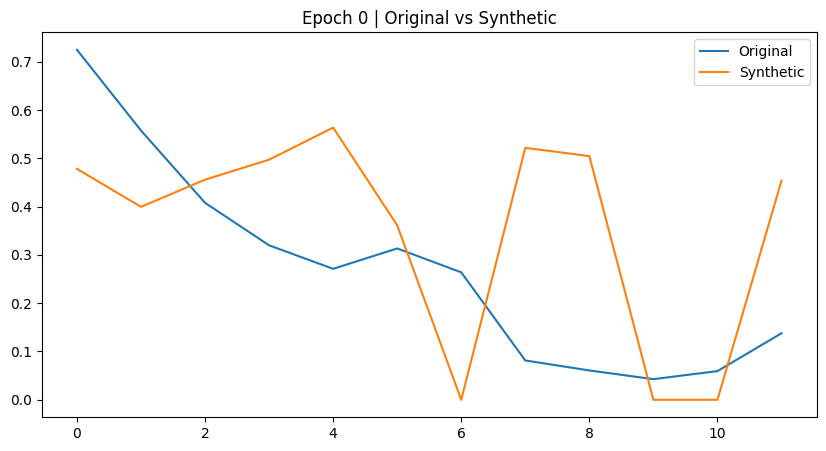

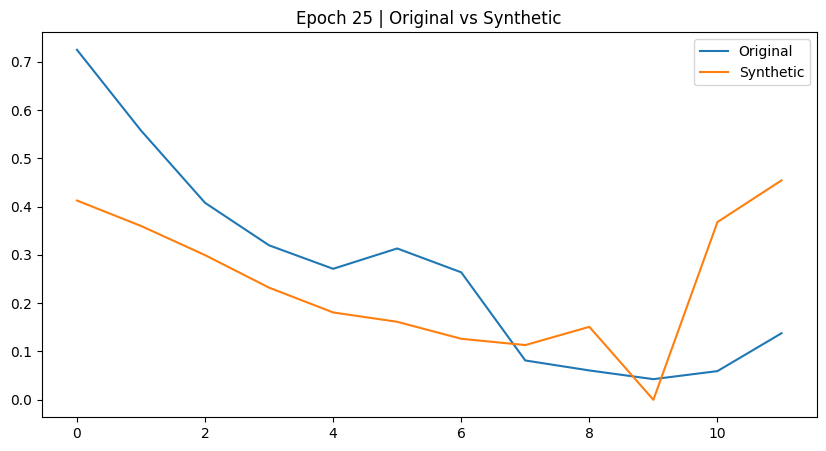

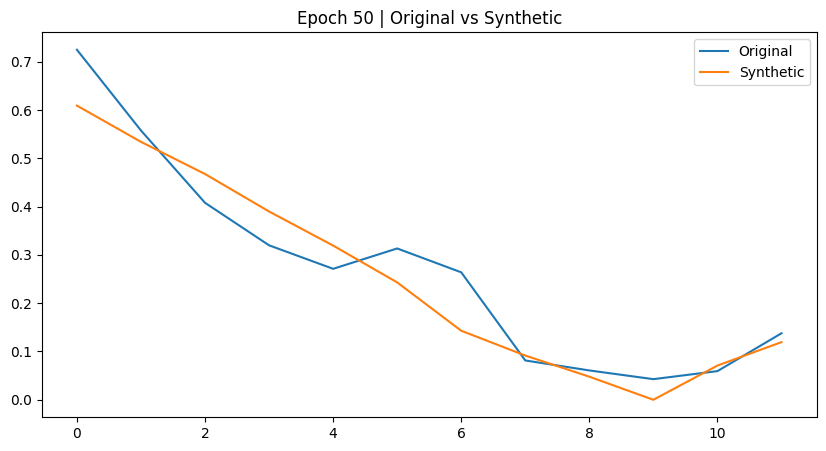

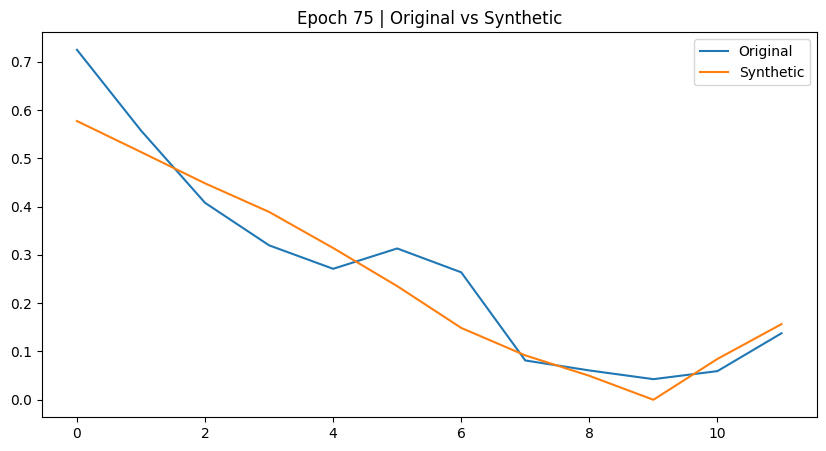

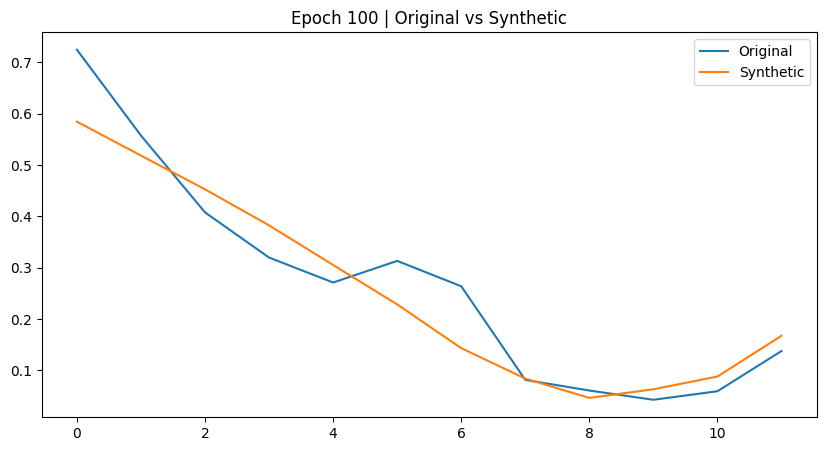

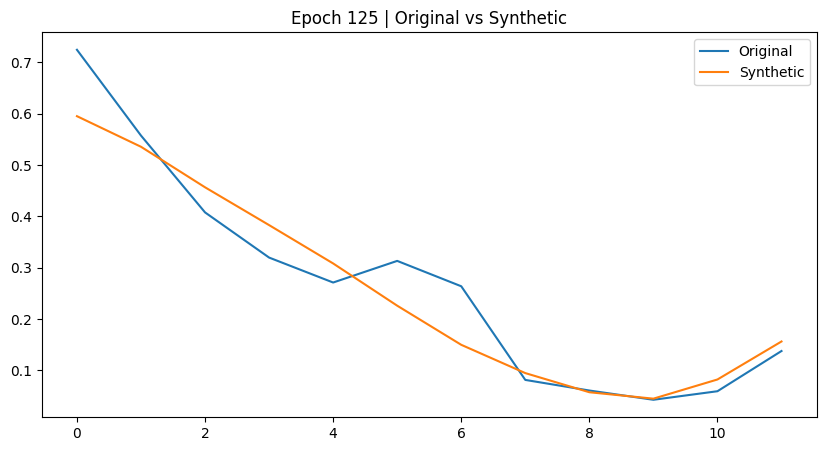

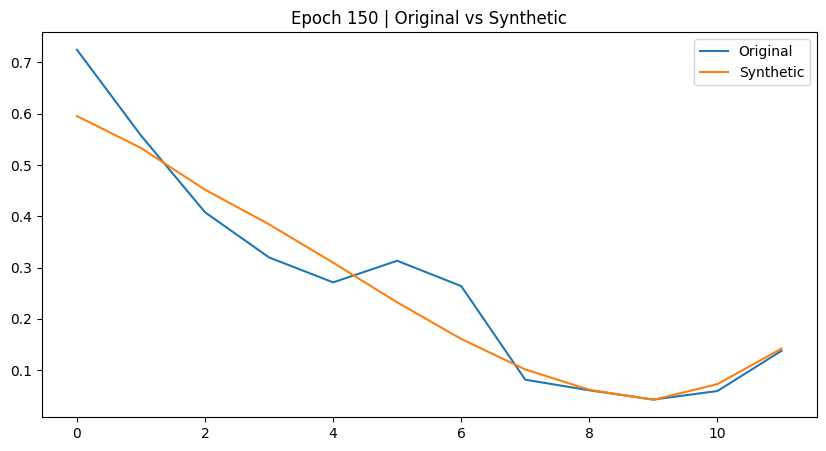

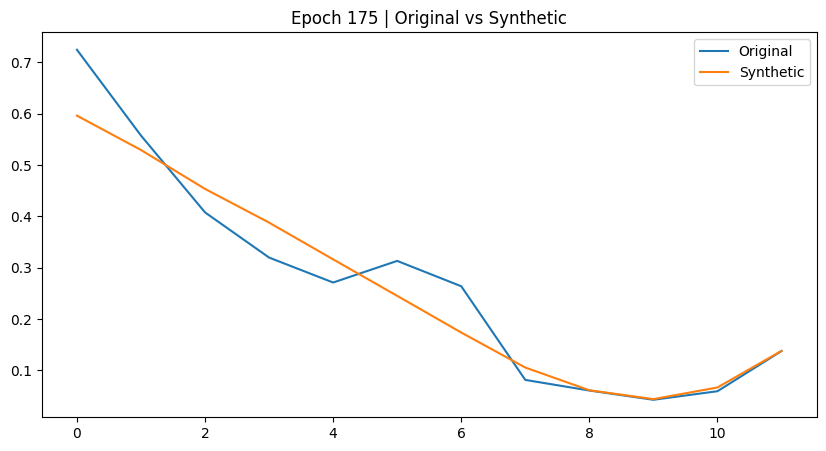

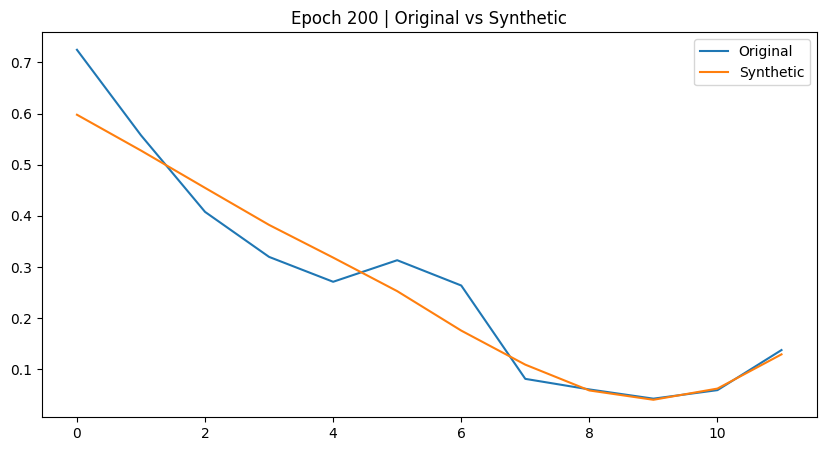

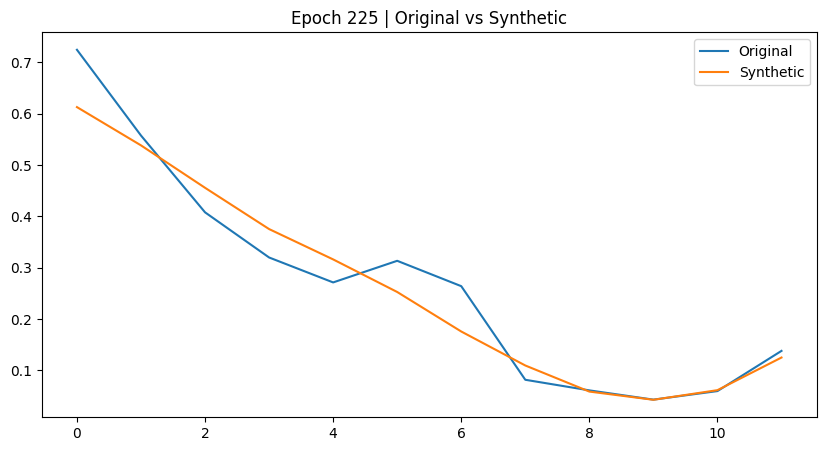

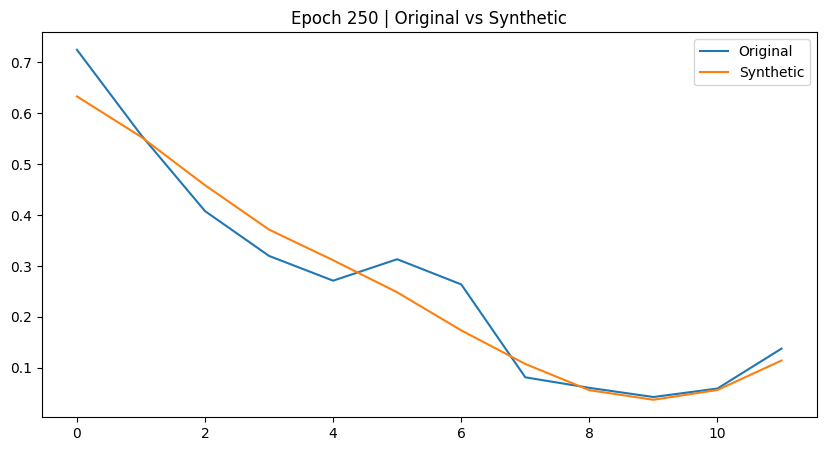

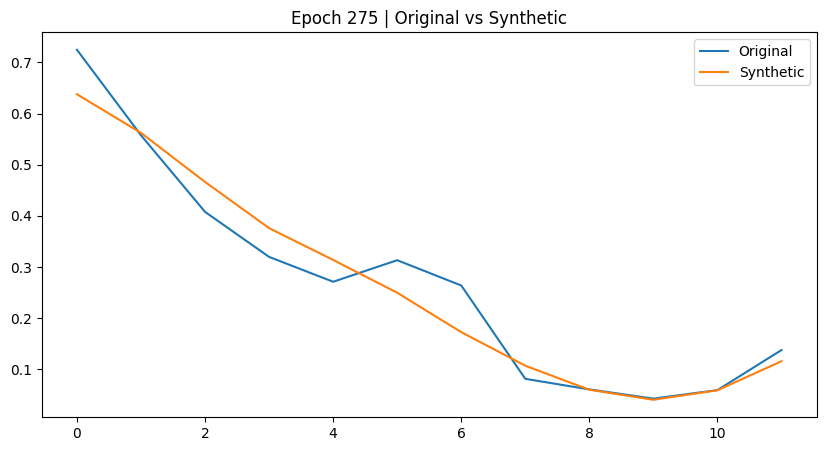

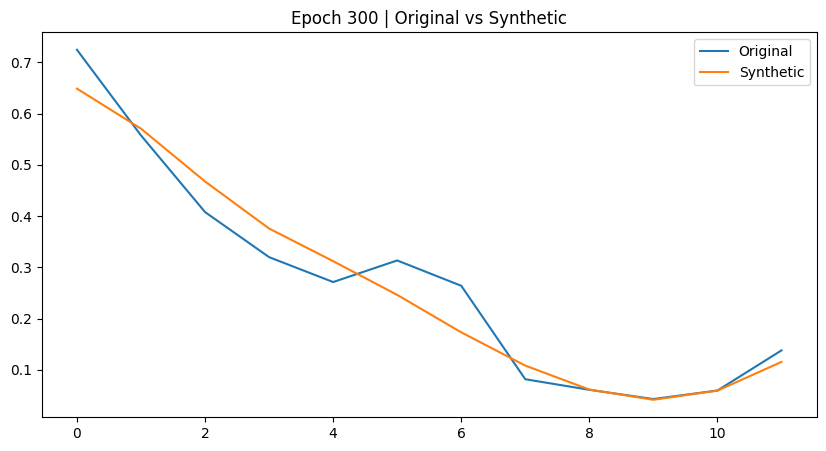

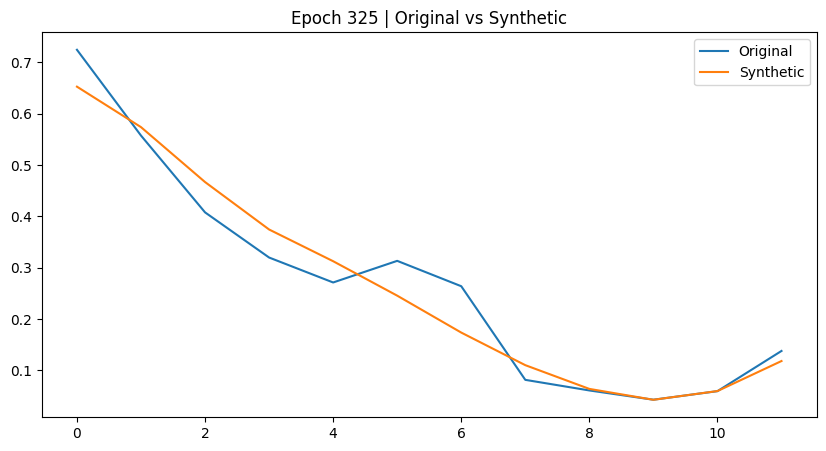

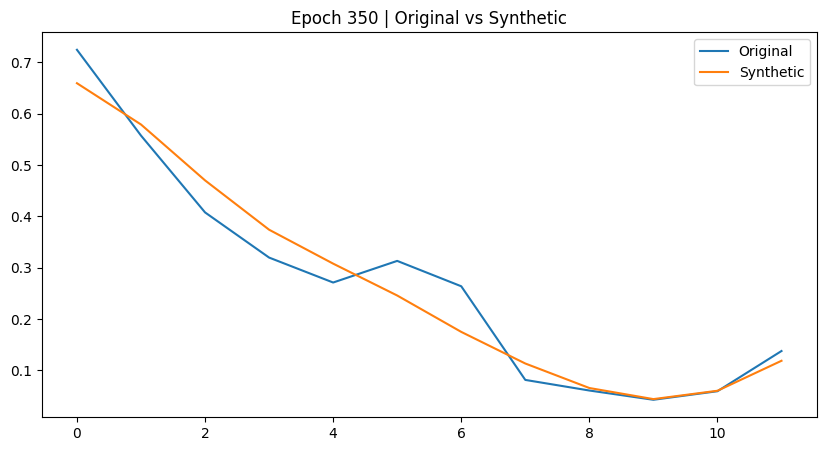

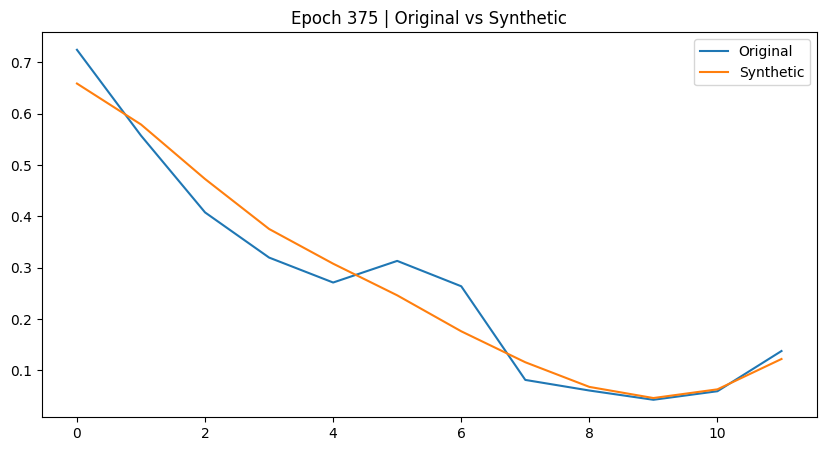

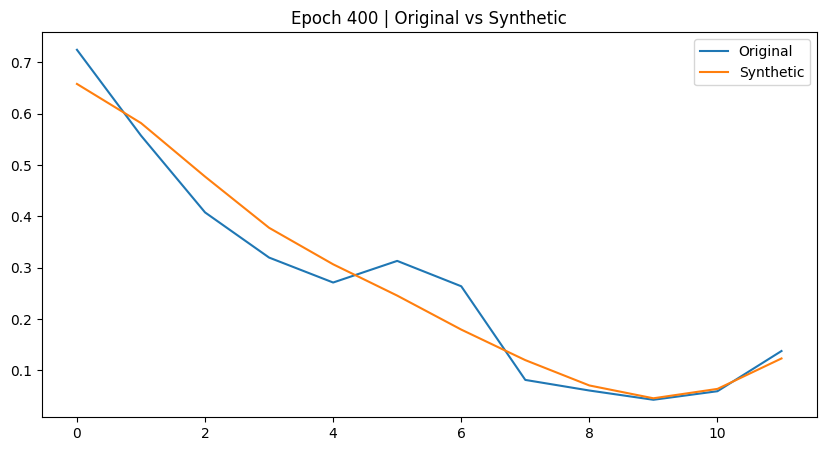

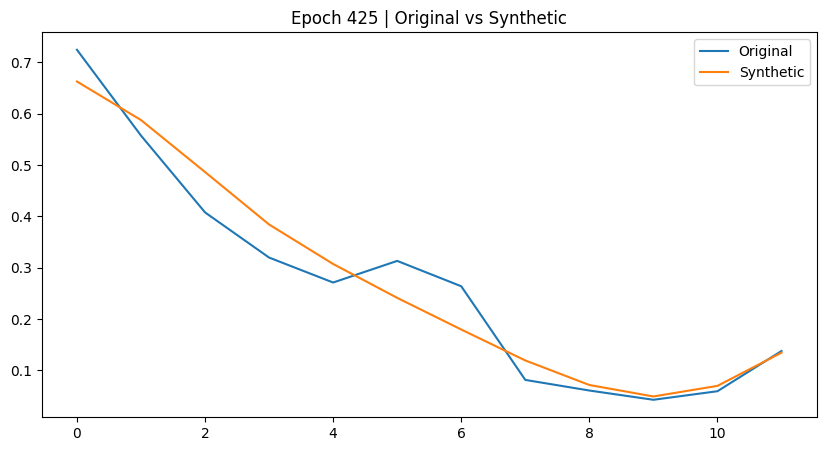

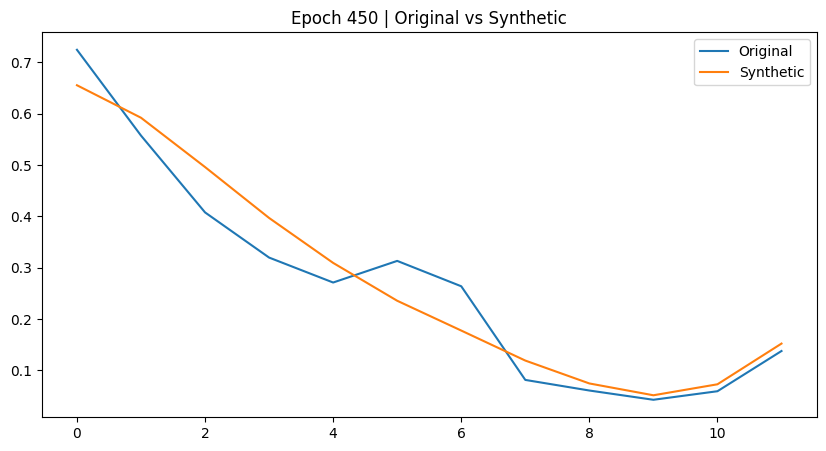

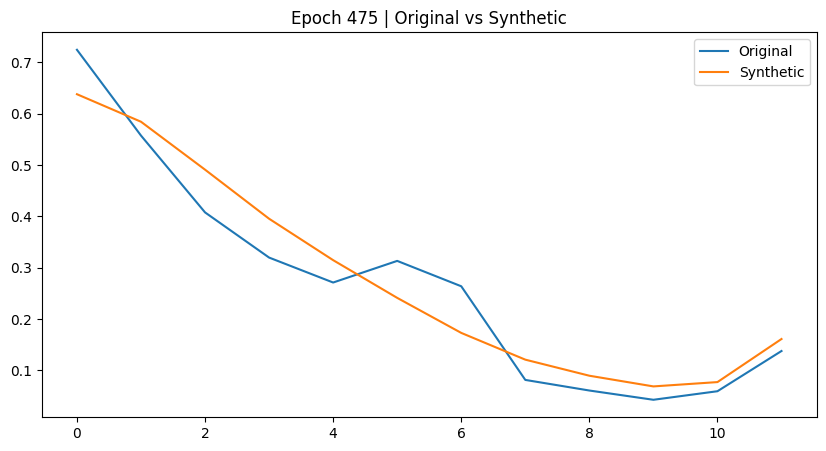

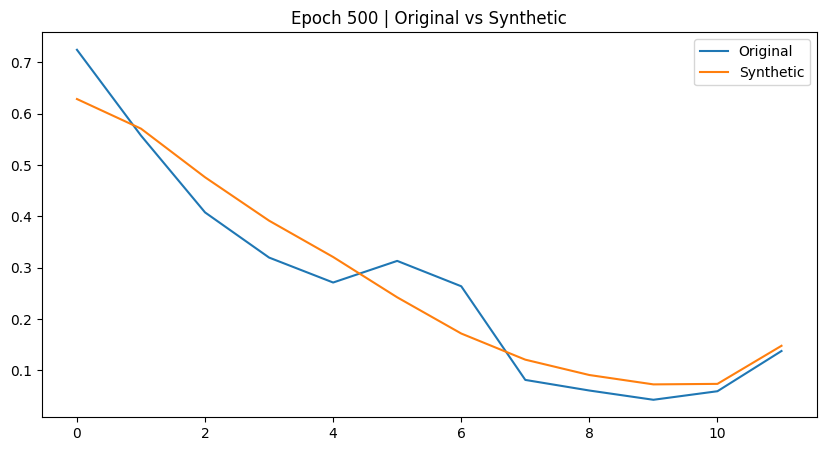

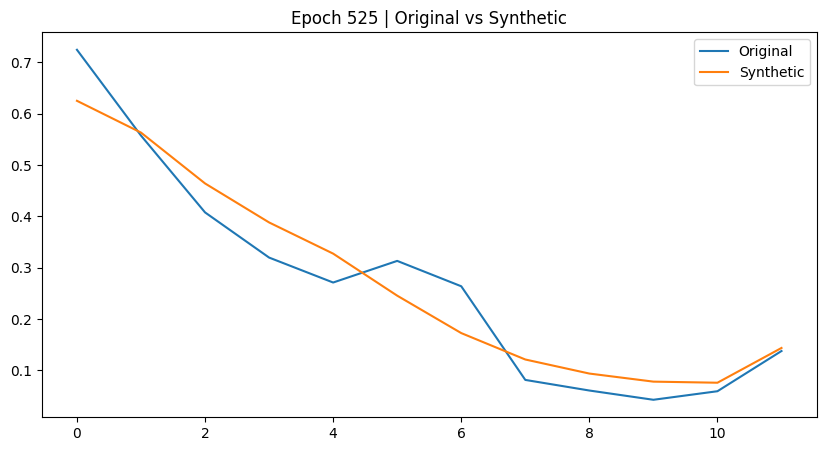

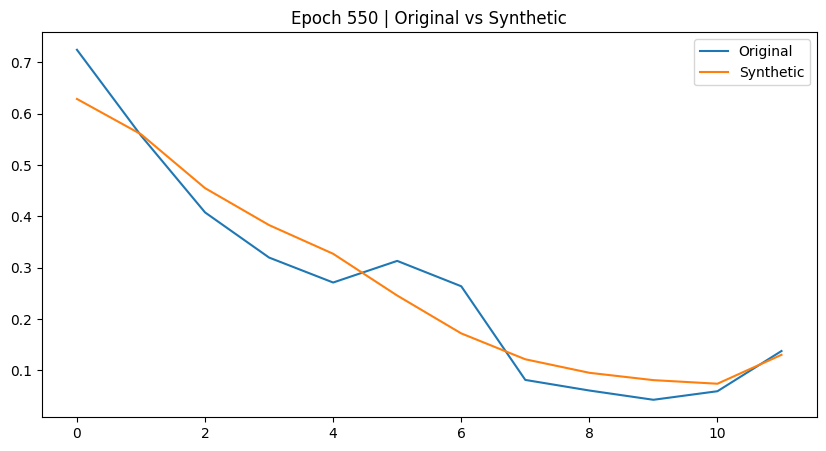

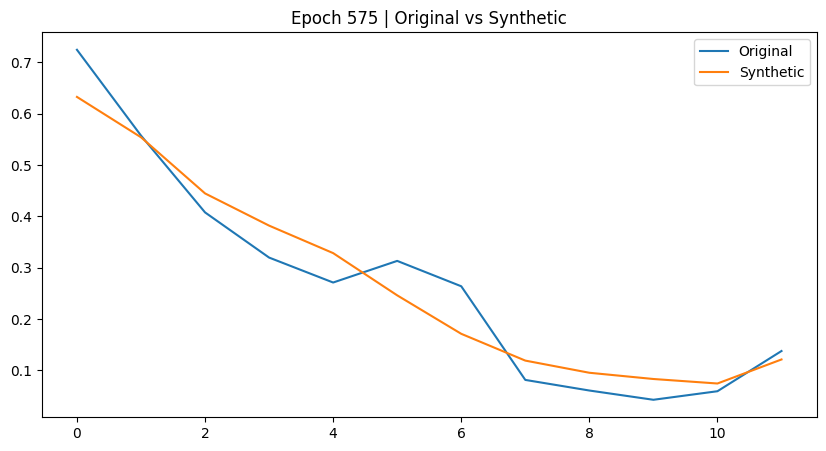

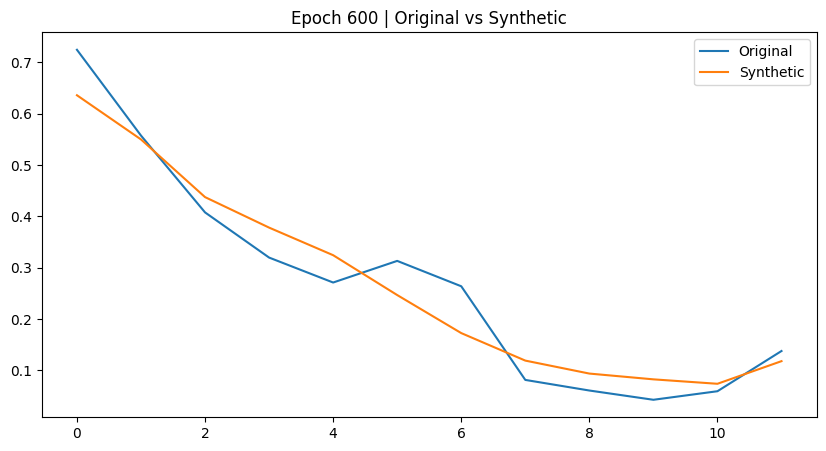

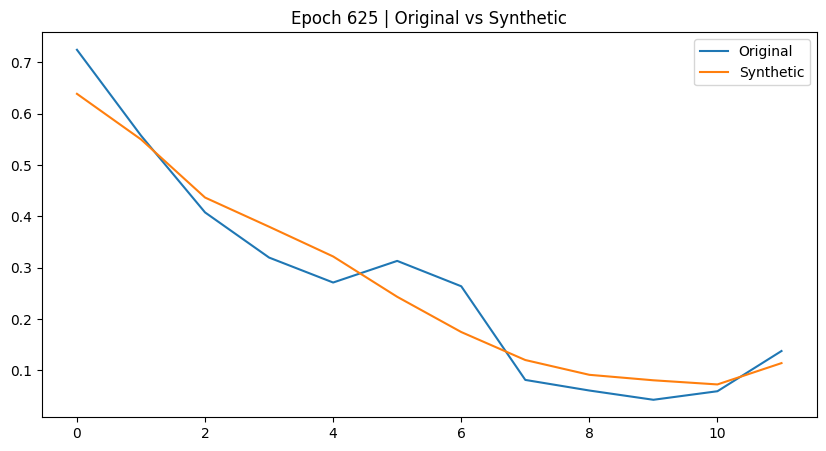

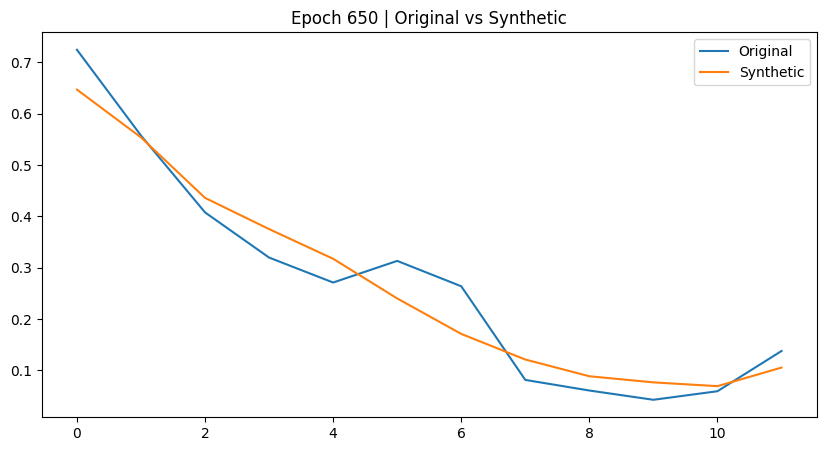

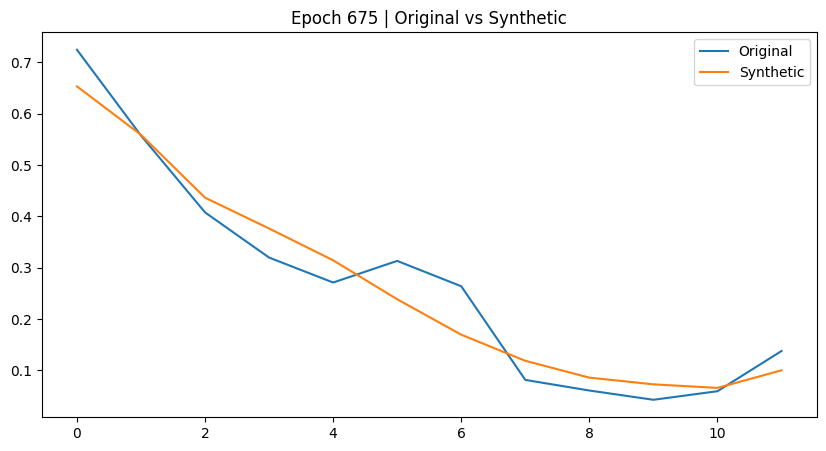

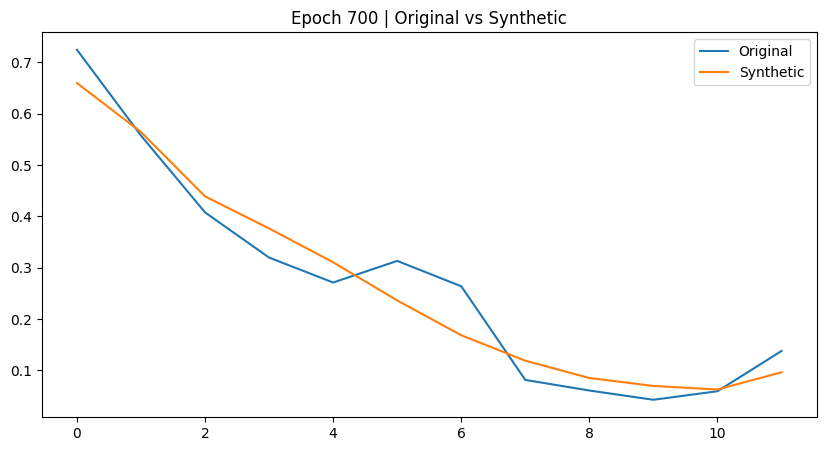

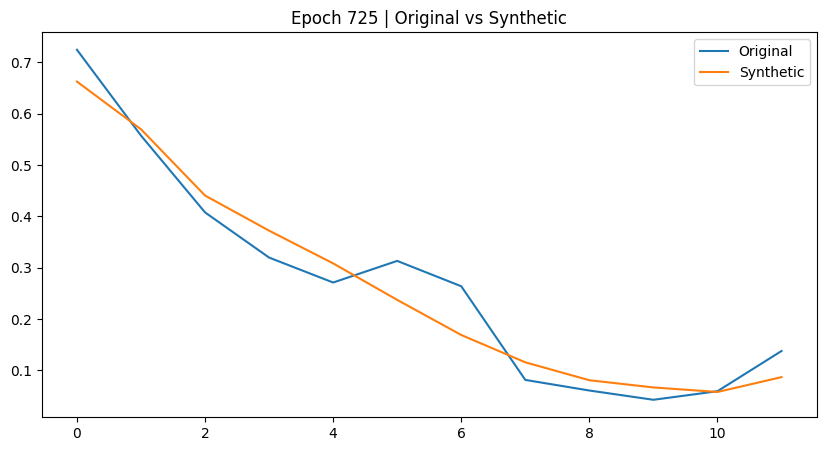

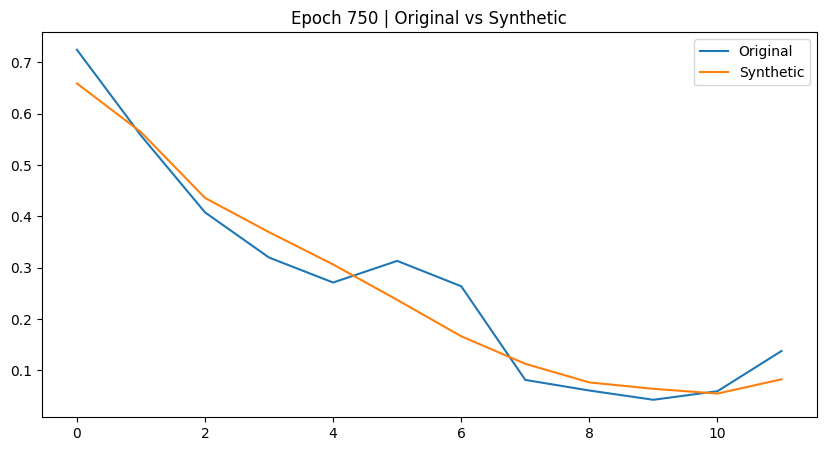

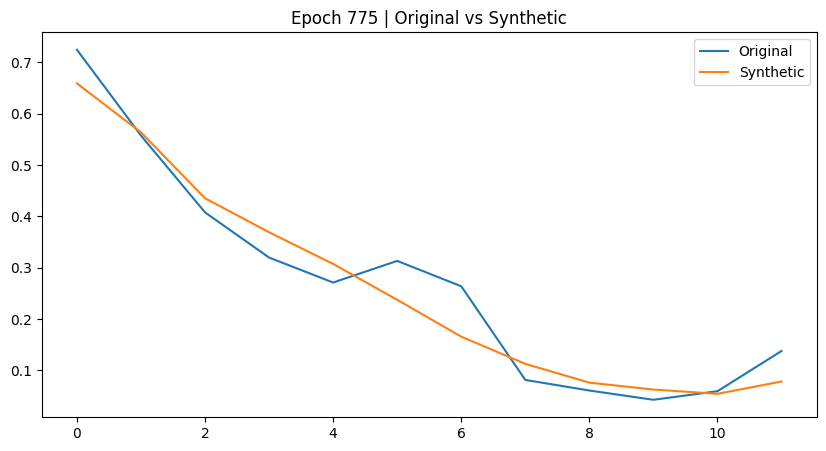

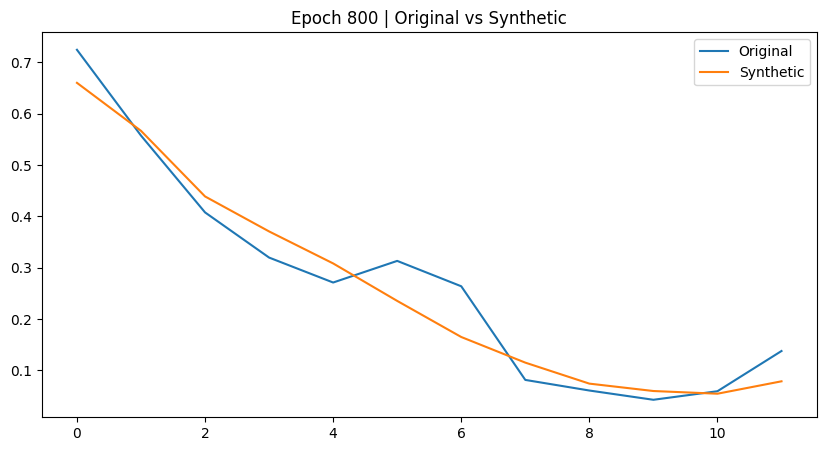

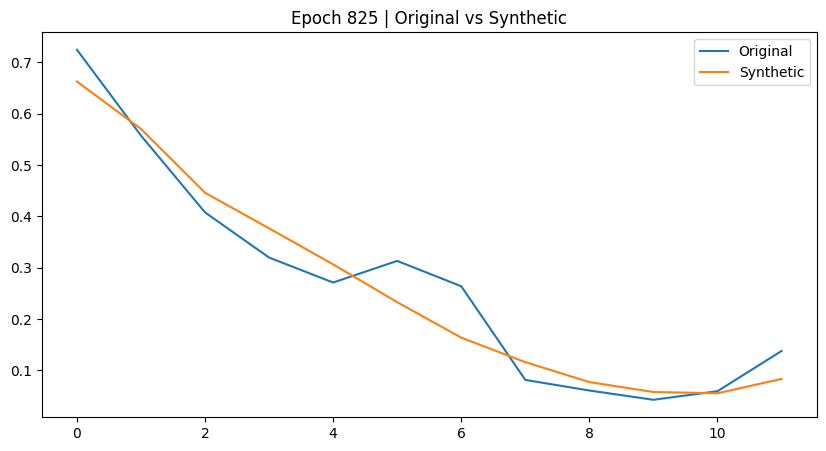

In [16]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"
else:
    model_path = f"{model_name}_checkpoint.pth"

    train_losses, val_losses = train_autoencoder(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_path
    )

## Evaluate Training

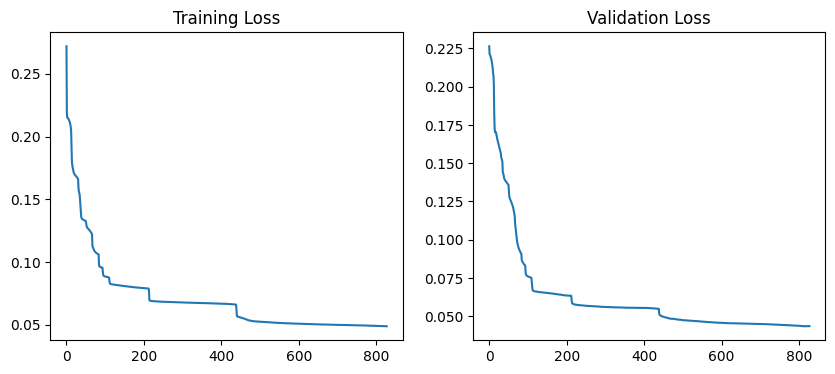

In [17]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [18]:
if not TEST_EXISTING_MODEL:
    smallest_val_loss = val_losses[-11]
    smallest_train_loss = train_losses[-11]
    print(f'Smallest Val Loss: {smallest_val_loss} | Smallest Train Loss: {smallest_train_loss}')

Smallest Val Loss: 0.04342790001205036 | Smallest Train Loss: 0.04893730541682679


## Testing Model

In [19]:
if model_name == "LSTM_AE":
    print("LSMT_AE")
    test_model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    print("FCAE")
    test_model = FCAE(verbose=True).to(hyperparameters['device'])

# load model state dict
test_model.load_state_dict(torch.load(model_path))

LSMT_AE


<All keys matched successfully>

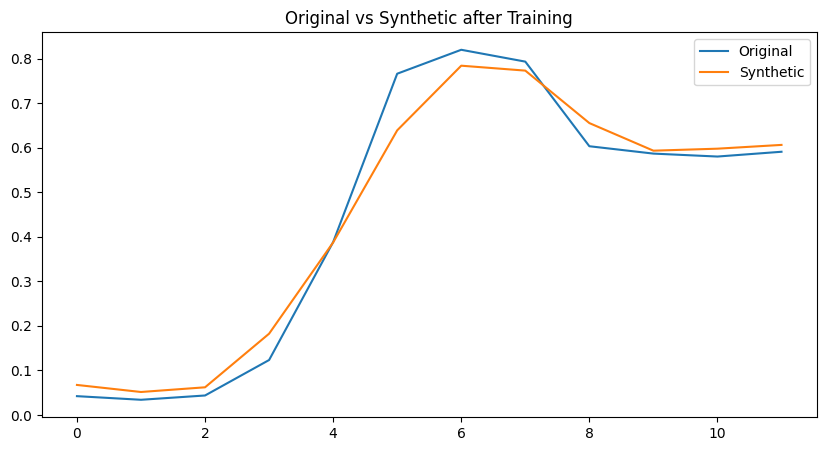

In [47]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [21]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [22]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([6996, 12, 5]), torch.Size([865, 12, 5]), torch.Size([865, 12, 5]))

In [23]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [24]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [25]:
result.shape

(8726, 12, 5)

In [26]:
result_unscaled = scaler.inverse_scale_complete_dataset(result, input_data_is_sequential=True)

In [27]:
no, seq, dim = result_unscaled.shape
data_to_save = result_unscaled.reshape(no, seq*dim)

In [48]:
# np.savetxt(f'mitv_{no}_{seq}_{dim}_autoencoder_{model_name}_unscaled.csv', data_to_save, delimiter=',')

### Check on synthetic data

In [29]:
df = pd.DataFrame(result_unscaled.reshape(-1, dim))
df.describe()

,0,1,2,3,4
count,104712.000000,104712.000000,104712.0,1.047120e+05,104712.000000
mean,3196.964111,279.349884,0.0,1.266347e-09,40.697540
std,1877.608887,14.884194,0.0,4.027184e-07,39.007477
min,0.000000,247.150009,0.0,0.000000e+00,0.000000
25%,1297.783539,271.447609,0.0,0.000000e+00,0.000000
50%,3544.542114,281.756729,0.0,0.000000e+00,31.727083
75%,4784.060547,291.352676,0.0,0.000000e+00,86.484615
max,7716.058105,307.195068,0.0,1.302962e-04,110.427353


In [30]:
traffic_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,3244.668912,282.208136,0.086792,0.000233,44.397306
std,1946.247953,12.114907,0.901360,0.006145,39.195308
min,0.000000,243.390000,0.000000,0.000000,0.000000
25%,1252.500000,273.605500,0.000000,0.000000,1.000000
50%,3402.000000,283.650000,0.000000,0.000000,40.000000
75%,4849.500000,292.060000,0.000000,0.000000,90.000000
max,7260.000000,307.330000,42.000000,0.250000,100.000000
